FinCEN文章を解析する_02（各国の時間変化）

第一回：https://qiita.com/s_zh/items/b7c7eb7bc2af98b850d7

# 内容について

前回の記事で全期間中の各金融機関のなどの状況を解析したり、国別でデータを見ましたが、今回は年単位で各国の状況を見てみます。目標は各国の送金関係の時間変化を可視化することです。今回はその前処理として、まず各国の送金の時間変化についておおよその状況を掴みます。

https://nlp.stanford.edu/projects/histwords/


ソースコードはこちらになります。

https://github.com/lightondust/topics_by_jupyter_notebook/blob/master/FinCEN_02.ipynb

Colabに上げてNeo4j Sandboxと組み合わせればブラウザだけで解析することもできるはずです（ライブラリを適宜インストールする必要がありますが、必要な方はこちらの記事をご参照くださいhttps://qiita.com/s_zh/items/3b183e258bcd6506e8cb）

# ライブラリ読み込み、データベースアクセスの準備

お約束の構文です。

In [1]:
import plotly.express as px
import numpy as np

In [2]:
from neo4j import GraphDatabase
from tqdm.notebook import tqdm
import json

import pandas as pd

In [4]:
auth_path = './data/neo4j_graph/auth.json'
with open(auth_path, 'r') as f:
    auth = json.load(f)

# ローカルの場合は通常 uri: bolt(or neo4j)://localhost:7687, user: neo4j, pd: 設定したもの
# サンドボックスの場合は作成画面から接続情報が見られます
uri = 'neo4j://localhost:7687'
driver = GraphDatabase.driver(uri=uri, auth=(auth['user'], auth['pd']))

# Sandboxの場合はこんな感じ
# uri = 'bolt://54.175.38.249:35275'
# driver = GraphDatabase.driver(uri=uri, auth=('neo4j', 'spray-missile-sizing'))

# 年別の傾向

年別のレコードを取得して集計します。送金額をamount、送金回数をcountとします。

In [5]:
with driver.session() as session:
    res = session.run('''
    MATCH (n:Filing)
    RETURN n.begin.year as year, sum(n.amount) as amount, count(n) as count
    ORDER BY year
    ''')

In [6]:
res_df = pd.DataFrame([r.data() for r in res])

In [7]:
res_df.shape

(18, 3)

送金量について見てみます。

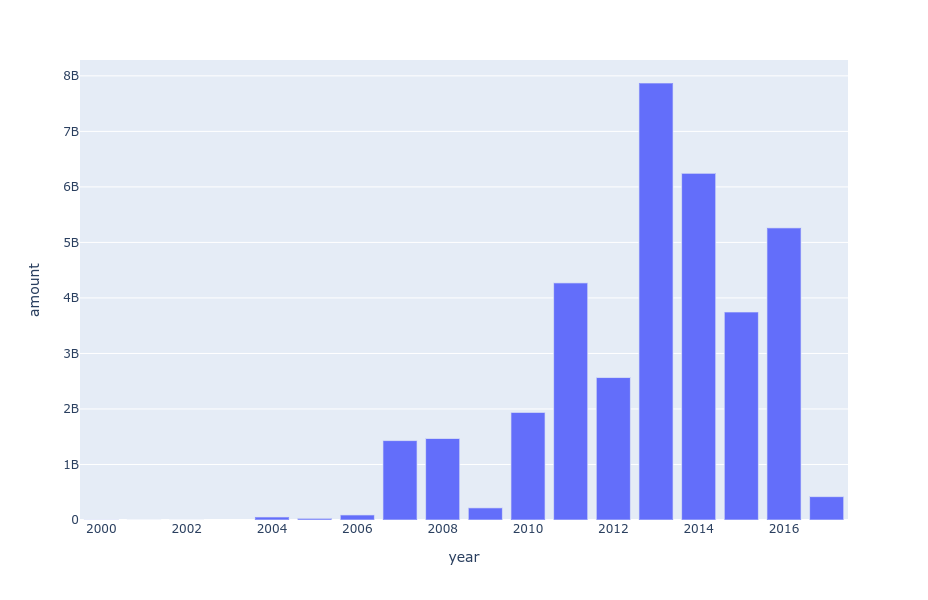

In [9]:
px.bar(res_df, x='year', y='amount')

金融危機と同じ時期に急増しているのは興味深いですね。２００９年の急減はヨーロッパ通貨危機とかぶるのも何か関係があるのでしょうか。２０１３年にピークをつけているようです。

では送金回数を見てみましょう。

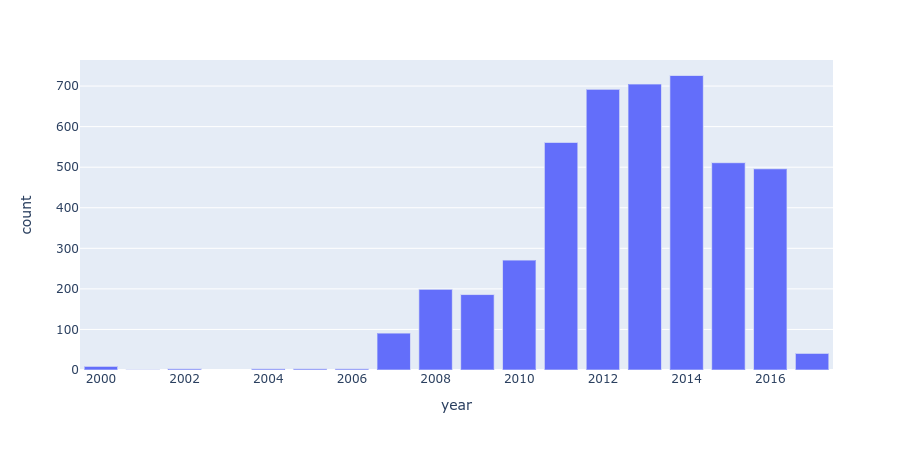

In [8]:
px.bar(res_df, x='year', y='count')

基本的に２０１４年までは増加傾向のようです。２００９年の金額の急落はお金がないから減ったのかな、２０１６年は件数が減っているのに金額が増えたのも実は潤っているからか、と邪推したくなりますね。

# amount by country

国別に見てみましょう。国別の金額と回数の集計をします。

In [10]:
with driver.session() as session:
    res = session.run('''
    MATCH (n:Filing)-[:BENEFITS]-(:Entity)--(c:Country)
    RETURN c.name as country, n.begin.year as year, sum(n.amount) as amount, count(n) as count
    ORDER BY year
    ''')

日付のないデータを落とします。

In [11]:
res_df = pd.DataFrame([r.data() for r in res])
res_df.shape

(465, 4)

In [12]:
res_df = res_df.dropna()
res_df.shape

(460, 4)

国別、年別に集計します。

まずは金額から

In [13]:
res_df_country = res_df.groupby(['country']).sum()

In [14]:
res_df_country_order_by_amount = res_df_country.sort_values('amount', ascending=False)
res_df_country_order_by_amount

,year,amount,count
country,,,
Russia,24138.0,7.279861e+09,486
Latvia,22132.0,3.947781e+09,498
Switzerland,24136.0,3.744860e+09,445
Singapore,22132.0,2.947456e+09,238
Hong Kong,20123.0,2.655467e+09,263
...,...,...,...
Jamaica,4020.0,1.942582e+04,2
Greece,2009.0,5.738450e+03,1
Jersey,2011.0,3.224220e+03,1


送金回数も同様です。

In [14]:
res_df_country_order_by_count = res_df_country.sort_values('count', ascending=False)
res_df_country_order_by_count

,year,amount,count
country,,,
Latvia,22132.0,3.947781e+09,498
Russia,24138.0,7.279861e+09,486
Switzerland,24136.0,3.744860e+09,445
United States,28143.0,1.824221e+09,267
Hong Kong,20123.0,2.655467e+09,263
...,...,...,...
Puerto Rico,2015.0,1.670000e+05,1
Sri Lanka,2008.0,2.300000e+05,1
Qatar,2014.0,6.965325e+05,1


上位国の推移を見てみます。

In [61]:
country_list_amount = res_df_country_order_by_amount.index[:7]
country_list_count = res_df_country_order_by_count.index[:7]

金額の推移です。

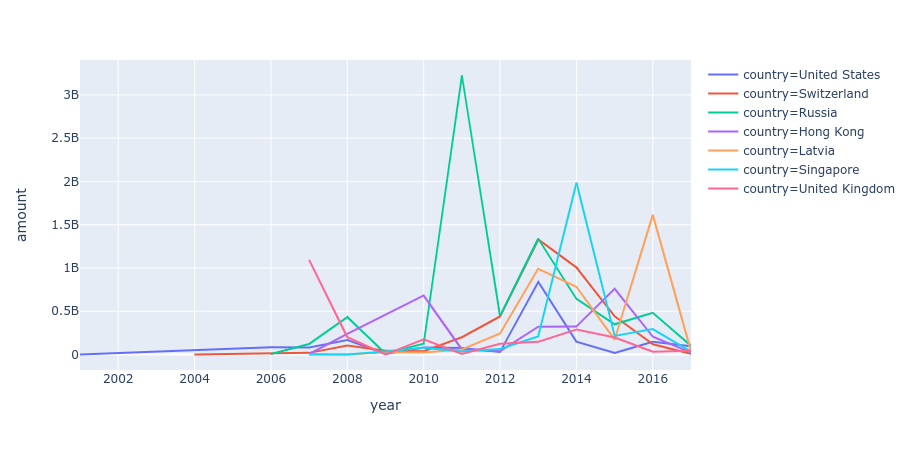

In [62]:
res_df_filtered_by_country = res_df[res_df.country.isin(country_list_amount)]

px.line(res_df_filtered_by_country, x='year', y='amount', color='country')

時間と共に大きく変化しています。ロシアへの送金は２０１１年に集中していて、その後は減少傾向です。一方でシンガポール、スウェーデン、ラトビアは近年増えています。

送金回数の推移です。

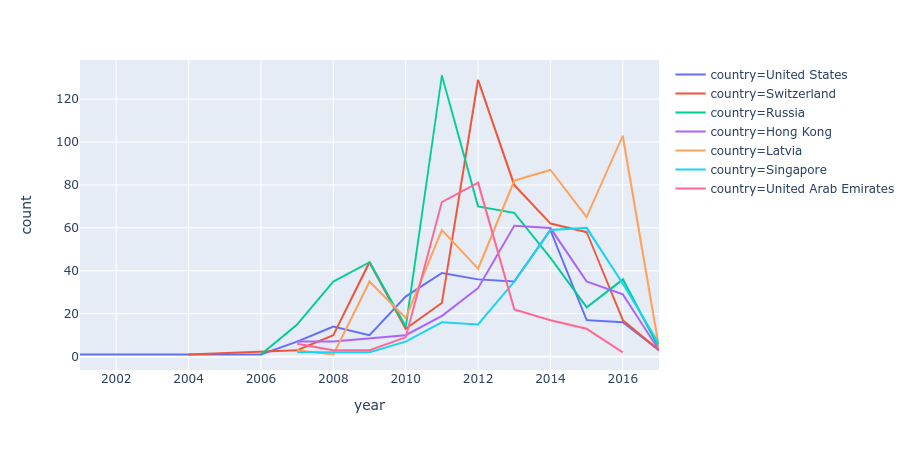

In [63]:
res_df_filtered_by_country = res_df[res_df.country.isin(country_list_count)]
px.line(res_df_filtered_by_country, x='year', y='count', color='country')

ラトビアは概ねトレンドを描いて上昇傾向であるように見えます。金額では目立たないUAEが浮上してきました。

これを時々見かける時間変化の動画にすると次のような感じになります。

https://public.flourish.studio/visualisation/3942049/

# Bar Chart Race

時間変化の動画を作るためのソースコードが下記です

In [15]:
information_format = {}
for rec in res_df.to_dict(orient='records'):
    country = rec['country']
    year = rec['year']
    amount = rec['amount']
    if not year:
        continue
    if country in information_format:
        information_format[country][year] = amount
    else:
        information_format[country] = {year: amount}
    

In [16]:
country_year_amount_df = pd.DataFrame(information_format)

In [17]:
country_year_amount_df = country_year_amount_df.sort_index().T

In [18]:
country_year_amount_df

,2000.0,2001.0,2002.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0
Peru,5700446.06,NaN,NaN,NaN,NaN,NaN,1961821.00,NaN,NaN,NaN,NaN,NaN,1.801819e+05,2.904759e+05,3.625025e+06,3.044300e+07,NaN
United States,NaN,7769.89,NaN,54297237.53,NaN,83950000.0,79593802.00,1.680078e+08,4799923.17,81111267.42,7.504763e+07,2.865208e+07,8.391423e+08,1.491771e+08,1.721105e+07,1.478597e+08,95363351.00
Belarus,NaN,NaN,9402.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.958548e+07,NaN,NaN
Spain,NaN,NaN,NaN,20000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.243146e+06,7.968587e+06,1.944970e+03,1.500000e+04,NaN
Switzerland,NaN,NaN,NaN,195000.00,NaN,NaN,18788349.56,1.042613e+08,44588788.40,38177154.77,1.990626e+08,4.396638e+08,1.328279e+09,1.004730e+09,4.415746e+08,1.183473e+08,7191512.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Maldives,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.013589e+05,NaN,NaN
Puerto Rico,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.670000e+05,NaN,NaN
Saudi Arabia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.793496e+07,1.528821e+07,NaN
Lao People's Democratic Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.388230e+06,NaN


In [29]:
country_year_amount_df.to_csv('./data/fincen/country_year_amount.csv')

このままだと国旗が表示されません。国旗を表示させるためには各国の国旗のURLを与える必要があります。

## flags

In [52]:
country_flags = pd.read_csv('./data/country_flags.csv', header=None)
country_flags.columns = ['country', 'cotinent', 'flag']

In [53]:
country_flags = country_flags.set_index('country')

In [54]:
country_flags

,cotinent,flag
country,,
Angola,Africa,https://www.countryflags.io/ao/flat/64.png
Burundi,Africa,https://www.countryflags.io/bi/flat/64.png
Benin,Africa,https://www.countryflags.io/bj/flat/64.png
Burkina Faso,Africa,https://www.countryflags.io/bf/flat/64.png
Botswana,Africa,https://www.countryflags.io/bw/flat/64.png
...,...,...
Solomon Islands,Oceania,https://www.countryflags.io/sb/flat/64.png
Tonga,Oceania,https://www.countryflags.io/to/flat/64.png
Tuvalu,Oceania,https://www.countryflags.io/tv/flat/64.png


In [55]:
country_year_amount_df.shape

(107, 17)

In [56]:
country_year_amount_df.join(country_flags)

,2000.0,2001.0,2002.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,cotinent,flag
Peru,5700446.06,NaN,NaN,NaN,NaN,NaN,1961821.00,NaN,NaN,NaN,NaN,NaN,1.801819e+05,2.904759e+05,3.625025e+06,3.044300e+07,NaN,Americas,https://www.countryflags.io/pe/flat/64.png
United States,NaN,7769.89,NaN,54297237.53,NaN,83950000.0,79593802.00,1.680078e+08,4799923.17,81111267.42,7.504763e+07,2.865208e+07,8.391423e+08,1.491771e+08,1.721105e+07,1.478597e+08,95363351.00,NaN,NaN
Belarus,NaN,NaN,9402.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.958548e+07,NaN,NaN,Europe,https://www.countryflags.io/by/flat/64.png
Spain,NaN,NaN,NaN,20000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.243146e+06,7.968587e+06,1.944970e+03,1.500000e+04,NaN,Europe,https://www.countryflags.io/es/flat/64.png
Switzerland,NaN,NaN,NaN,195000.00,NaN,NaN,18788349.56,1.042613e+08,44588788.40,38177154.77,1.990626e+08,4.396638e+08,1.328279e+09,1.004730e+09,4.415746e+08,1.183473e+08,7191512.77,Europe,https://www.countryflags.io/ch/flat/64.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Maldives,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.013589e+05,NaN,NaN,Asia,https://www.countryflags.io/mv/flat/64.png
Puerto Rico,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.670000e+05,NaN,NaN,Americas,https://www.countryflags.io/pr/flat/64.png
Saudi Arabia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.793496e+07,1.528821e+07,NaN,Asia,https://www.countryflags.io/sa/flat/64.png
Lao People's Democratic Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.388230e+06,NaN,NaN,NaN


In [57]:
country_year_amount_df.join(country_flags).to_csv('./data/fincen/country_year_amount_flag.csv')